In [7]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os

In [2]:
def discrete_cmap():
    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3']
    cmap3 = colors.ListedColormap(cpool, 'rooms')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'icons')
    cm.register_cmap(cmap=cmap3)

    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3', 'd3d5d7']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)
discrete_cmap()

/tmp/ipykernel_2698/2660030060.py:28: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)


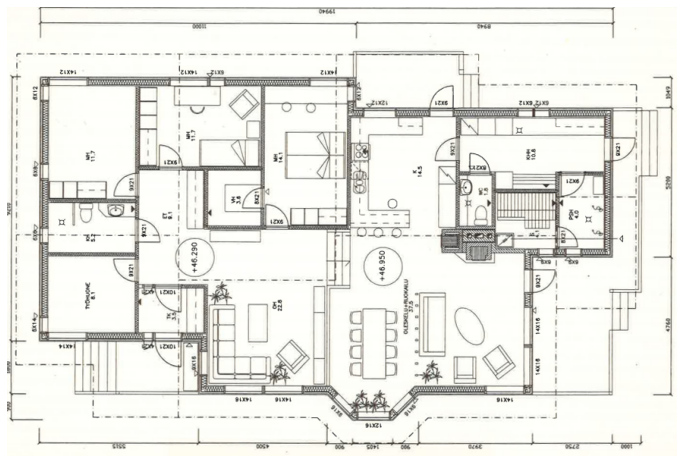

In [4]:
image_name = 'original.png'
original = cv2.imread(image_name)
try:
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
except:
    original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(original)

# from segmentation import predict
# rooms_pred, icons_pred, heatmaps = predict(original)


In [5]:
from brute_force import recognize
from recognition import *

verbose = True

prediction = recognize(original, verbose)

walls, doors, windows, segmentation = prediction['walls'], prediction['doors'], prediction['windows'], prediction['segmentation']

walls = attach_openings(walls, doors + windows, verbose)
walls = calculate_wall_widths(walls, prediction['segmentation']['walls'], verbose)
walls = normalize_wall_points(walls, 5)

walls = classify_wall_elements(walls, original, verbose)
symbols = classify_symbols(prediction['symbols'], original, verbose)

res = {'walls': walls, 'symbols': symbols}

/mnt/c/Users/joaodavid/Desktop/practical/Recognition/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 17/17 [00:02<00:00,  6.02it/s]


In [6]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

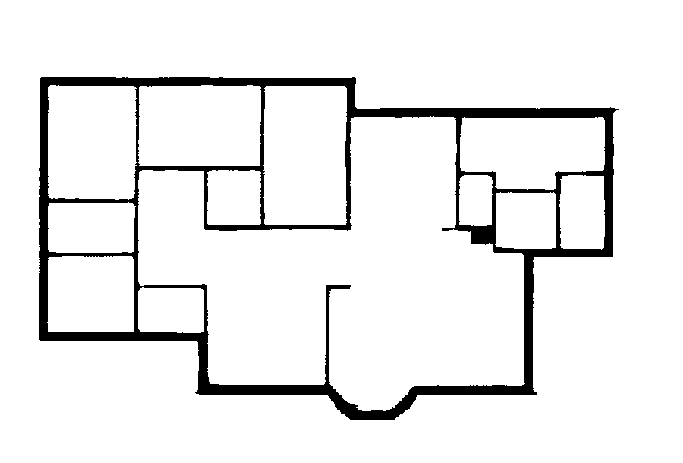

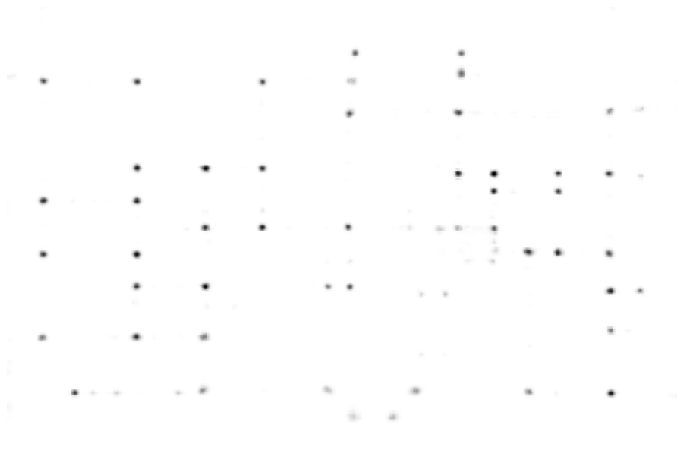

In [10]:
path = f'./qualitative/{image_name.split("/")[-1].split(".")[0]}/'
os.makedirs(path)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(~segmentation['walls']//255, cmap='gray', interpolation='none')

plt.savefig(path + 'walls.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(1-segmentation['heatmaps'], cmap='gray', interpolation='none')
plt.savefig(path + 'heatmaps.png', bbox_inches='tight')
plt.show()

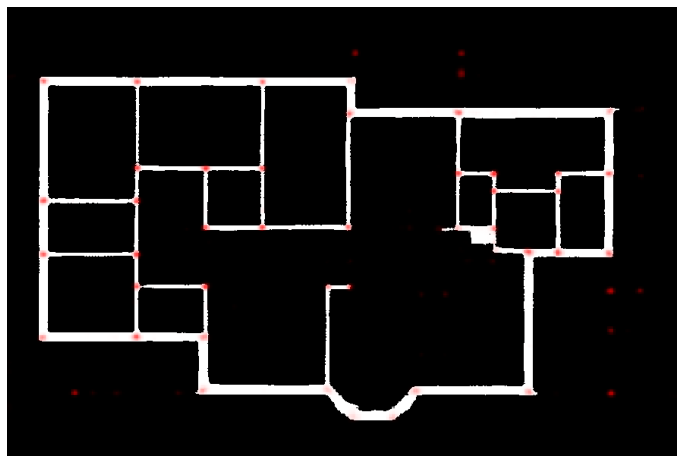

In [7]:
plt.figure(figsize=(12,12))
plt.axis('off')
transparent = cv2.cvtColor(original, cv2.COLOR_RGB2RGBA)
zero = np.zeros_like(transparent)
one = np.ones_like(transparent)

walls = zero.copy()
walls[segmentation['walls'] == 255] = [255, 255, 255, 255]
walls[segmentation['walls'] == 0] = [0, 0, 0, 255]
plt.imshow(walls)

reds = np.intp(np.stack([one[:,:,0]*255, zero[:,:,0], zero[:,:,0], segmentation['heatmaps']*255], axis=-1))
plt.imshow(reds, interpolation='none')

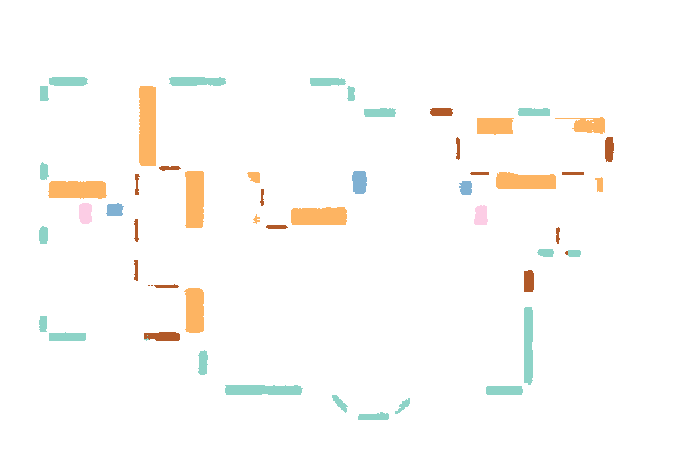

In [11]:
icon_seg = segmentation['icons'].copy()
# walls_closed = as_image(rooms_pred == 2)
# doors_pixels = as_image(icons_pred ==  2)
# windows_pixels = as_image(icons_pred ==  1)
# closets_pixels = as_image(icons_pred == 3)
# toilets_pixels = as_image(icons_pred == 5)
# sinks_pixels = as_image(icons_pred == 6)
# bathtubs_pixels = as_image(icons_pred == 9)

selected = [0, 1, 2, 3, 5, 6]

icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]
cpool = np.array(['#ffffff', '#8dd3c7', '#b15928', '#fdb462', '#ffff99', '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969', '#577a4d'])
# cpool = np.array(['#dcdcdc', '#8dd3c7', '#b15928', '#fdb462', '#ffff99', '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969', '#577a4d'])
cpool = list(cpool[selected])
cmap1 = colors.ListedColormap(cpool, 'selected_icons')
cm.register_cmap(cmap=cmap1)

negation = list(set(range(len(icon_classes))) - set(selected))
to = list(range(0, len(selected)))

for i in range(len(negation)):
    icon_seg[icon_seg == negation[i]] = 0
for i in range(len(selected)):
    icon_seg[icon_seg == selected[i]] = to[i]

selected_icons = list(np.array(icon_classes)[selected])

fig=plt.figure(figsize=(12,12))
ax = plt.axes()
plt.axis('off')
n_icons = len(selected_icons)
iseg = ax.imshow(np.intp(icon_seg), cmap='selected_icons', vmin=0, vmax=n_icons-0.1, interpolation='none')
# cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
# cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, cax=cax)
# cbar.ax.set_yticklabels(selected_icons, fontsize=20)
plt.savefig(path + 'iconsseg.png', bbox_inches='tight')

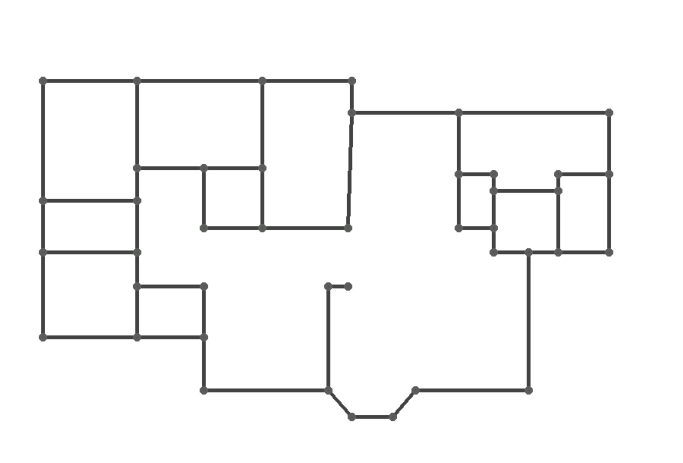

In [12]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'vector.png', bbox_inches='tight')

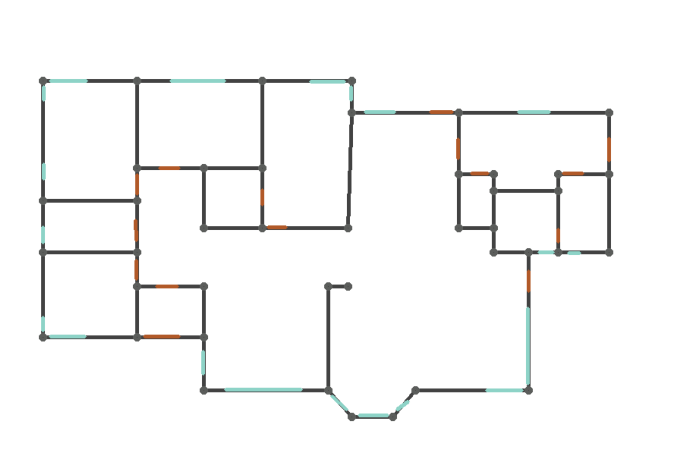

In [13]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)



plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'attached.png', bbox_inches='tight')

In [ ]:
def to_rgb(hex):
    hex = hex[1:]
    return tuple(tuple(int(hex[i:i+2], 16) for i in (0, 2, 4)))

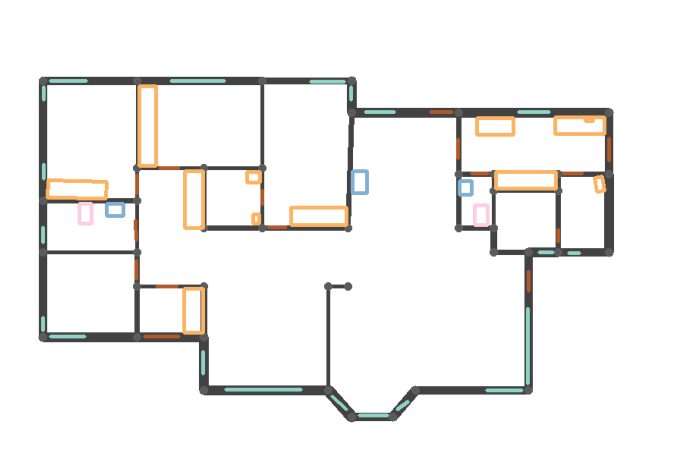

In [14]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), wall["width"])

alpha = 0.5
reconstr = cv2.addWeighted(reconstr, alpha, reconstr, 1 - alpha, 0)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)

# symbols = ('closet', 'toilet', 'sink', 'bathtub')
symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink']
# colors = ((158, 107, 26), (133, 218, 255),  (58, 126, 156), (201, 30, 173))
symbol_colors = [to_rgb(c) for c in cpool]
for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

# for wall in res['walls']:
#     centroid = np.intp(np.mean(wall['points'], axis=0))
#     reconstr = put_text(reconstr, str(wall['width']), centroid, 0.4)
#     if 'elements' in wall:
#         for el in wall['elements']:
#             if el['type'] == 'door':
#                 centroid = np.intp(np.mean(el['points'], axis=0))
#                 orientation = el['orientation'][-2:]
#                 reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7)

# for symbol in res['symbols']:
#     if symbol['type'] in ('toilet', 'sink'):
#         centroid = np.intp(np.mean(symbol['points'], axis=0))
#         reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'withicons.png', bbox_inches='tight')

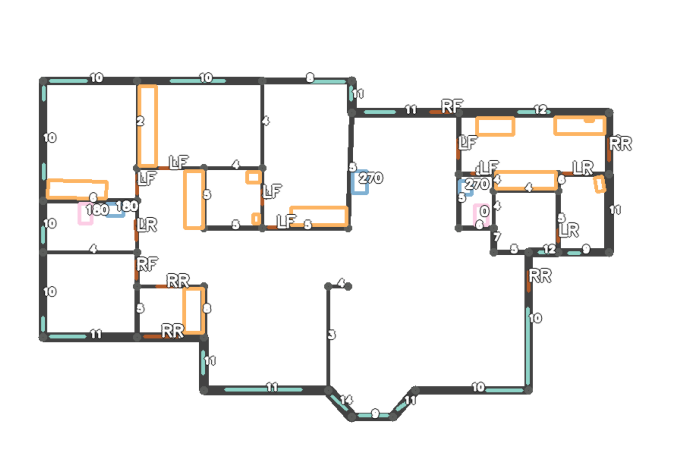

In [15]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), wall["width"])

alpha = 0.5
reconstr = cv2.addWeighted(reconstr, alpha, reconstr, 1 - alpha, 0)

for wall in res['walls']:
    s, e = wall['points']
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (141, 211, 199), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)

# symbols = ('closet', 'toilet', 'sink', 'bathtub')
symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink']
# colors = ((158, 107, 26), (133, 218, 255),  (58, 126, 156), (201, 30, 173))
symbol_colors = [to_rgb(c) for c in cpool]
for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

for wall in res['walls']:
    centroid = np.intp(np.mean(wall['points'], axis=0))
    reconstr = put_text(reconstr, str(wall['width']), centroid, 0.4)
    if 'elements' in wall:
        for el in wall['elements']:
            if el['type'] == 'door':
                centroid = np.intp(np.mean(el['points'], axis=0))
                orientation = el['orientation'][-2:]
                reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7)

for symbol in res['symbols']:
    if symbol['type'] in ('toilet', 'sink'):
        centroid = np.intp(np.mean(symbol['points'], axis=0))
        reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'allsemantics.png', bbox_inches='tight')

In [50]:
def draw_poly(img, points, colors, thickness):
    img = img.copy()
    for i in range(len(points)):
        p, q = points[i], points[(i+1)%len(points)]
        img = cv2.line(img, p, q, colors[i%len(colors)], thickness)
    return img


In [59]:
def put_text(img, text, pos, size=1, color=(255, 255, 255)):
    img = cv2.putText(
        img, text, pos,
        cv2.FONT_HERSHEY_SIMPLEX, size, (0, 0, 0), thickness=4, lineType=cv2.LINE_AA
    )
    img = cv2.putText(
        img, text, pos,
        cv2.FONT_HERSHEY_SIMPLEX, size, color, thickness=2, lineType=cv2.LINE_AA
    )
    return img

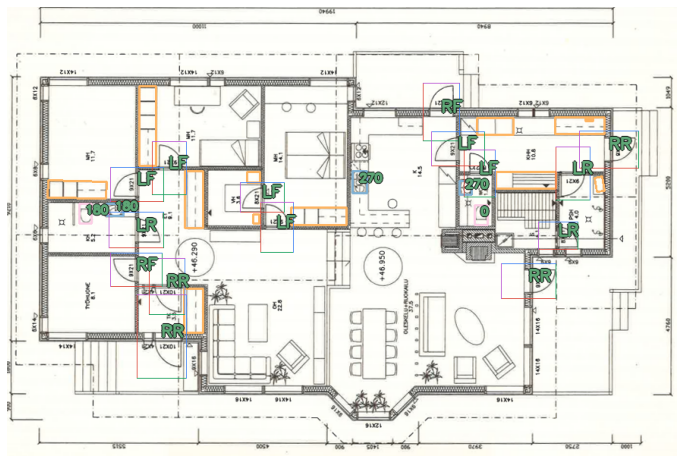

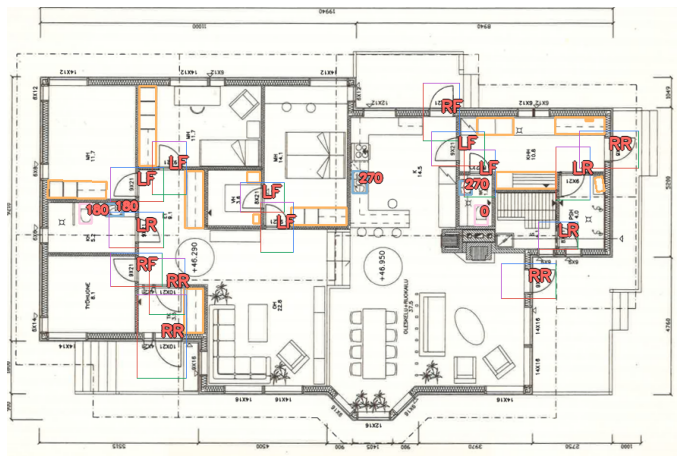

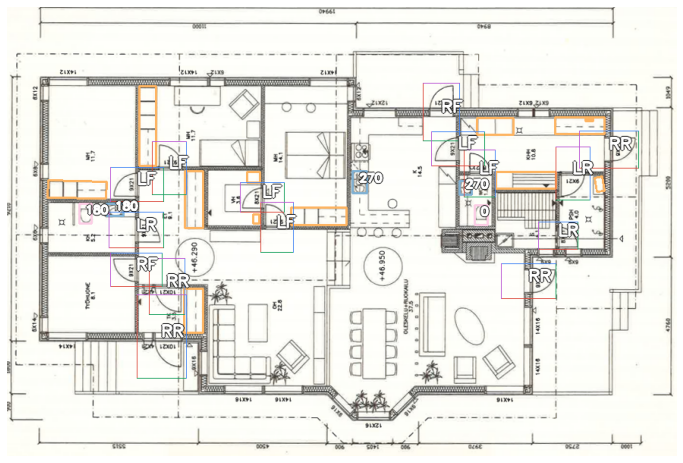

In [63]:

alpha = 0.5
reconstr = cv2.addWeighted(reconstr, alpha, reconstr, 1 - alpha, 0)

fontcolors = {'green': (95, 167, 119), 'red': (255, 105, 98), 'white': (255,255,255)}

symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink']
symbol_colors = [to_rgb(c) for c in cpool]

for cname, color in fontcolors.items():
    reconstr = np.copy(original)
    for symbol in res['symbols']:
        reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 2)

    for wall in res['walls']:
        if 'elements' in wall:
            for el in wall['elements']:
                s, e = el['points']
                if el['type'] == 'door':
                    # reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                    # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (255, 0, 0), 1)
                    reconstr = draw_poly(reconstr, np.intp(el['bounding_box']), ((219,68,55), (15,157,88), (66,133,244), (186,85,211)), 1)

    for symbol in res['symbols']:
        if symbol['type'] in ('toilet', 'sink'):
            centroid = np.intp(np.mean(symbol['points'], axis=0))
            reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5, color=color)

    for wall in res['walls']:
        centroid = np.intp(np.mean(wall['points'], axis=0))
        if 'elements' in wall:
            for el in wall['elements']:
                if el['type'] == 'door':
                    centroid = np.intp(np.mean(el['points'], axis=0))
                    orientation = el['orientation'][-2:]
                    reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7, color=color)

    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(reconstr)
    plt.savefig(path + f'symbols-{cname}.png', bbox_inches='tight')
    plt.show()